In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Optional

def visualize_outputs_and_targets(
    targets: pd.DataFrame,
    plots_dir: Path,
    file_name: str = "test.png",
    return_fig: bool = False,
    channel_labels: Optional[list[str]] = None,
    predictions: Optional[pd.DataFrame] = None,
    selected_channels: Optional[list[int]] = None,
) -> plt.Figure | None:

    # Determine which channels to plot
    n_channels: int = targets.shape[-1]
    if selected_channels is None:
        selected_channels = list(range(n_channels))

    if channel_labels is None:
        channel_labels = [f"Channel {i}" for i in range(n_channels)]

    # Create subplots for only the selected channels
    fig, _ = plt.subplots(
        ncols=1,
        nrows=len(selected_channels),
        figsize=(10, 2 * len(selected_channels)),
        sharex=True,
        squeeze=False,
    )

    for i, (ax, channel) in enumerate(zip(fig.axes, selected_channels)):
        # Plot target in orange
        sns.lineplot(
            data=targets.iloc[:, channel],
            ax=ax,
            linewidth=0.7,
            label="Target",
            color=(1.0, 0.498, 0.055),
            alpha=0.8 if predictions is not None else 1.0,
        )

        # Plot prediction in blue if provided
        if predictions is not None:
            sns.lineplot(
                data=predictions.iloc[:, channel],
                ax=ax,
                linewidth=0.7,
                label="Prediction",
                color=(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
                alpha=0.8,
            )

        # Labels and formatting
        ax.set_ylabel(channel_labels[channel], fontsize=12)
        ax.tick_params(axis='both', labelsize=10)
        ax.set_xlim(-100, len(targets) + 100)
        ax.grid(True)

        # Legend: only on first subplot if predictions are provided
        if predictions is not None and i == 0:
            handles, labels = ax.get_legend_handles_labels()
            ax.legend(
                handles=handles,
                labels=labels,
                loc="upper right",
                fontsize=10,
                ncol=2,
            )
        else:
            ax.get_legend().remove()

    fig.supylabel("Firing rate [Hz]", fontsize=14)
    fig.supxlabel("Time step", fontsize=14)

    fig.tight_layout()
    fig.savefig(plots_dir / file_name, dpi=300)

    if return_fig:
        return fig
    return None


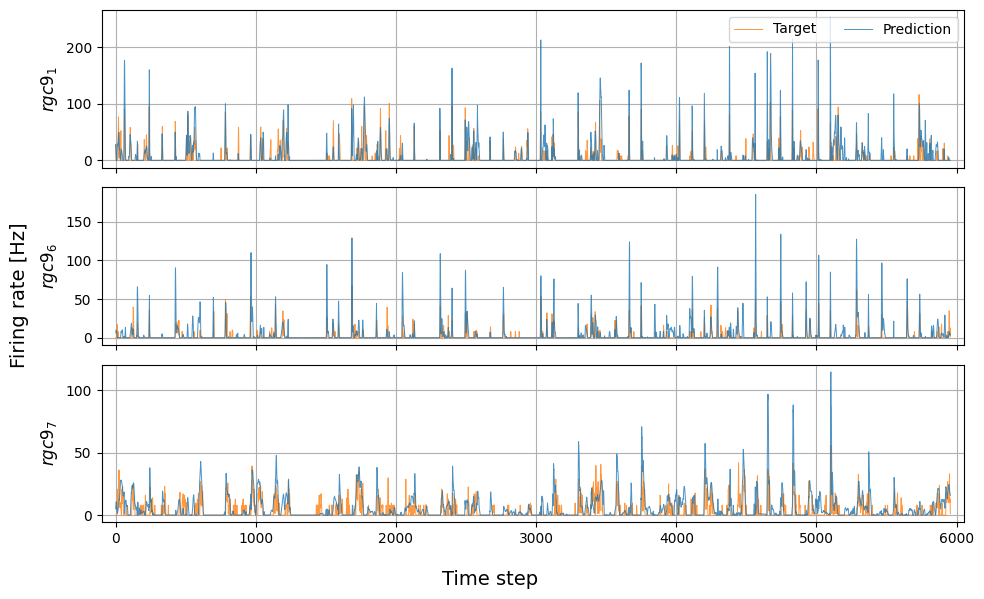

In [2]:
# csv_dir = Path("predictions")
# model_name = "3D"

# targets = pd.read_csv(csv_dir / model_name / "unscaled_targets.csv")
# predictions = pd.read_csv(csv_dir / model_name / "unscaled_outputs.csv")
targets = pd.read_csv("unscaled_targets.csv", sep=",")
predictions = pd.read_csv("EXP_REG_OgLinear_15x11_40_mse_9_STEP_1_RUN_4.csv", sep=",")

num_channels = 9 # 9, 14, 27
dataset_name = "rgc"
selected_channels = [0, 5, 6]

visualize_outputs_and_targets(
    targets=targets,
    plots_dir=Path("plots"),
    file_name="test.pdf",
    return_fig=False,
    selected_channels=selected_channels,  # Example of selecting specific channels
    channel_labels=[f"${dataset_name}{num_channels}_{{{c+1}}}$" for c in range(num_channels)],
    predictions=predictions
)

## Comparison plot - single channel

In [13]:
sns.color_palette("tab10")

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [43]:
def visualize_model_predictions_comparison(
    targets: pd.DataFrame,
    predictions_list: list[pd.DataFrame],
    model_names: list[str],
    plots_dir: Path,
    file_name: str = "comparison.png",
    return_fig: bool = False,
    selected_channels: Optional[list[int]] = None,
) -> plt.Figure | None:

    # Validate inputs
    if len(predictions_list) != len(model_names):
        raise ValueError("Length of predictions_list must match length of model_names")

    n_channels = targets.shape[-1]
    if selected_channels is None:
        selected_channels = list(range(n_channels))

    # Colors for model predictions
    # palette = sns.color_palette("tab10")
    palette = [(184, 0, 88), (0, 140, 249), (0, 110, 0), (178, 69, 2), (255, 146, 135), (89, 84, 214), (0, 198, 248), (135, 133, 0), (0, 167, 108), (189, 189, 189)]
    palette = [tuple(c / 255 for c in color) for color in palette]

    # Total plots: 1 (targets only) + len(predictions_list) for each model
    n_rows = len(predictions_list)
    fig, _ = plt.subplots(
        ncols=1,
        nrows=n_rows,
        figsize=(10, 2.5 * n_rows),
        sharex=True,
        squeeze=False,
    )

    for j, channel in enumerate(selected_channels):
        # Plot only the selected channel
        axes = fig.axes

        target_series = targets.iloc[:, channel]
        y_min = target_series.min() - 5
        y_max = target_series.max() + 10

        # Row 0: only targets (orange)
        # sns.lineplot(
        #     data=targets.iloc[:, channel],
        #     ax=axes[0],
        #     linewidth=0.7,
        #     label="Target",
        #     color=(1.0, 0.498, 0.055),
        # )
        # axes[0].set_ylabel("Target", fontsize=12)
        # axes[0].tick_params(axis="both", labelsize=10)
        # axes[0].set_xlim(-100, len(targets) + 100)
        # axes[0].grid(True)
        # axes[0].legend(loc="upper right", fontsize=10)

        # Rows 1..N: model predictions + greyed-out targets
        for i, (predictions, model_name) in enumerate(zip(predictions_list, model_names)):
            ax = axes[i]
            # Greyed out target
            sns.lineplot(
                data=targets.iloc[:, channel],
                ax=ax,
                linewidth=0.7,
                label="Target",
                color="gray",
                alpha=0.5,
            )
            # Model prediction
            sns.lineplot(
                data=predictions.iloc[:, channel],
                ax=ax,
                linewidth=0.7,
                label=model_name,
                color=palette[i],
                alpha=0.8,
            )

            ax.set_ylabel(model_name, fontsize=12)
            ax.tick_params(axis="both", labelsize=10)
            ax.set_xlim(-100, len(targets) + 100)
            ax.set_ylim(y_min, y_max)
            ax.grid(True)

            # Legend only on model rows
            # ax.legend(loc="upper right", fontsize=10, ncol=2)
            ax.get_legend().remove()

    fig.supylabel("Firing rate [Hz]", fontsize=14)
    fig.supxlabel("Time step", fontsize=14)

    fig.tight_layout()
    fig.savefig(plots_dir / file_name, dpi=300)

    if return_fig:
        return fig
    return None


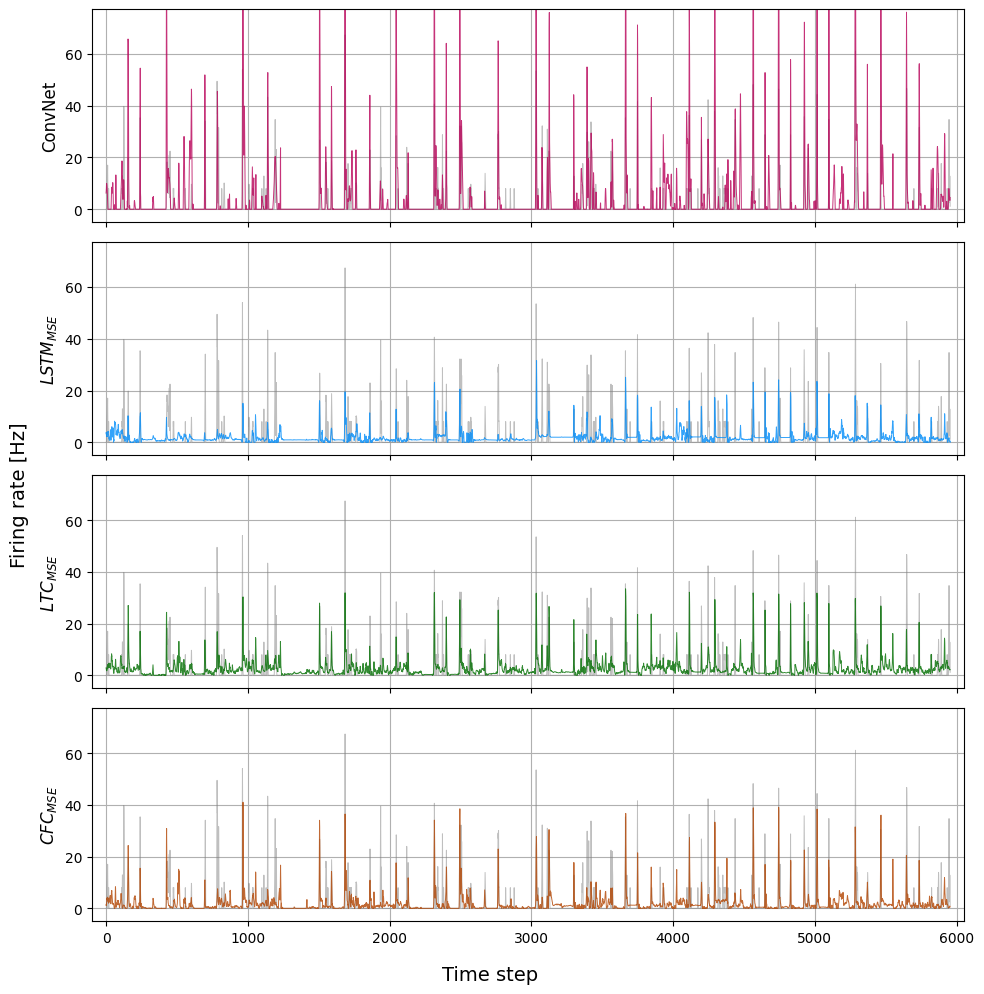

In [44]:
lstm = pd.read_csv("EXP_REG_SingleLSTM_40_mse_9_STEP_1_RUN_2.csv", sep=",")
cfc = pd.read_csv("EXP_REG_SimpleCFC_40_mse_9_STEP_1_RUN_3.csv", sep=",")
ltc = pd.read_csv("EXP_REG_SimpleLTC_40_mse_9_STEP_1_RUN_1.csv", sep=",")
convnet = pd.read_csv("EXP_REG_OgLinear_15x11_40_mse_9_STEP_1_RUN_4.csv", sep=",")

# apply max(0, x) to all predictions
lstm = lstm.clip(lower=0)
cfc = cfc.clip(lower=0)
ltc = ltc.clip(lower=0)
convnet = convnet.clip(lower=0)

targets = pd.read_csv("unscaled_targets.csv", sep=",")

predictions_list = [convnet, lstm, ltc, cfc]
model_names = ["ConvNet", "$LSTM_{MSE}$", "$LTC_{MSE}$", "$CFC_{MSE}$"]
selected_channels = [5]  # Example of selecting specific channels

visualize_model_predictions_comparison(
    targets=targets,
    predictions_list=predictions_list,
    model_names=model_names,
    plots_dir=Path("plots"),
    file_name="comparison.pdf",
    return_fig=False,
    selected_channels=selected_channels,  # Example of selecting specific channels
)

In [21]:
sns.color_palette("tab10")

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]